# Marigold: Repurposing Diffusion-Based Image Generators for Monocular Depth Estimation

[![Website](https://img.shields.io/badge/Project-Website-1081c2)](https://arxiv.org/abs/2312.02145)
[![GitHub](https://img.shields.io/github/stars/prs-eth/Marigold?style=default&label=GitHub%20★&logo=github)](https://github.com/prs-eth/Marigold)
[![Paper](https://img.shields.io/badge/arXiv-PDF-b31b1b)](https://arxiv.org/abs/2312.02145)
[![Hugging Face Space](https://img.shields.io/badge/🤗%20Hugging%20Face-Space-yellow)](https://huggingface.co/spaces/prs-eth/marigold)
[![Hugging Face Model](https://img.shields.io/badge/🤗%20Hugging%20Face-Model-green)](https://huggingface.co/prs-eth/marigold-depth-v1-0)
[![License](https://img.shields.io/badge/License-Apache--2.0-929292)](https://www.apache.org/licenses/LICENSE-2.0)

![Teaser](https://share.phys.ethz.ch/~pf/bingkedata/marigold/static/teaser_collage_transparant.png)



The necessary code to run [Marigold](https://marigoldmonodepth.github.io) is present in this notebook, using google's hardware.

Last updated: 2024-03-28


### To execute a cell, click the *play* button in front.

---

# 🛠️ 1 Setup

In [ ]:
# @title 💻 1.1 Check CUDA and Python Version (tested with CUDA 12.2 + Python 3.10.12)

# This notebook is supposed to be connected to NVIDIA drivers with CUDA.
# If this doesn't load check that GPU is selected as hardware accelerator under Edit -> Notebook settings.
!nvidia-smi
!python -V

Sat Feb 22 04:16:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# @title 1.2 👆 Select Checkpoint
!pip install ipywidgets==7.7.1 --quiet

from IPython.display import display
import ipywidgets as widgets
import shutil

ckpt_dic = {
    "Original (higher quality)": "prs-eth/marigold-v1-0",
    "LCM (faster)": "prs-eth/marigold-lcm-v1-0",
}

ckpt_name = 'LCM (faster)'
ckpt_path = ckpt_dic[ckpt_name]
w = widgets.Dropdown(
    options=['Original (higher quality)', 'LCM (faster)'],
    value=ckpt_name,
    description='Checkpoint:',
)


def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        ckpt_name = change['new']
        ckpt_path = ckpt_dic[ckpt_name]
        # print(f"Change to checkpoint: {ckpt_name} ({ckpt_path})")

w.observe(on_change)

display(w)
# print(f"{ckpt_path = }")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.0 MB/s eta 0:00:00


Dropdown(description='Checkpoint:', index=1, options=('Original (higher quality)', 'LCM (faster)'), value='LCM…

## 1.3 🏗️ Installation and Initialization

We provide two ways to run the pipeline. You can choose either ONE to run:

### 🅱 1.3-A Using code from the [full repository](https://github.com/prs-eth/marigold)

In [ ]:
# @title 📦 i. Clone repository

%%shell
cd /content

if [ -d "Marigold" ]; then
    cd Marigold
    git pull
else
    git clone https://github.com/prs-eth/Marigold.git
    cd Marigold
fi


Cloning into 'Marigold'...
remote: Enumerating objects: 633, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 633 (delta 218), reused 152 (delta 152), pack-reused 370 (from 2)
Receiving objects: 100% (633/633), 5.70 MiB | 19.79 MiB/s, done.
Resolving deltas: 100% (371/371), done.


In [ ]:
# @title 🔨 ii. Install dependencies (might take minutes)
%%shell

cd /content/Marigold

# pip install -r requirements.txt --upgrade  --quiet
pip install accelerate diffusers matplotlib scipy torch transformers --quiet

# for progress bar
pip install ipywidgets==7.7.1 --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.6 MB/s eta 0:00:00


In [ ]:
# @title 🔧 iii. Setup directories

import os

# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")

os.chdir(repo_dir)



In [ ]:
# @title 🏇 iv. Initialize pipeline

# change model cache directory
# !export HF_HOME=/content/Marigold/checkpoint

from marigold import MarigoldPipeline

pipe = MarigoldPipeline.from_pretrained(ckpt_path)

pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler%2Fscheduler_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

text_encoder%2Fconfig.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer%2Fspecial_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet%2Fconfig.json:   0%|          | 0.00/1.85k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer%2Fmerges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer%2Ftokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer%2Fvocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae%2Fconfig.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

### 🅰 1.3-B Using [d🧨ffusers](https://github.com/huggingface/diffusers) [community pipeline](https://github.com/huggingface/diffusers/tree/main/examples/community#marigold-depth-estimation) (easiest, but might be updated slower)



In [ ]:
# @title 🔨 i. Install dependencies

!pip install --upgrade "diffusers>=0.25.0" --quiet

# !pip install ipywidgets==7.7.1 --quiet


In [ ]:
# @title 🔧 ii. Setup directories
import os


# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")


os.makedirs(repo_dir, exist_ok=True)
os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

os.chdir(repo_dir)

In [ ]:
# @title 🏇 iii. Initialize pipeline

# change model cache directory
!export HF_HOME=$(pwd)/checkpoint

from diffusers import DiffusionPipeline

pipe = DiffusionPipeline.from_pretrained(
    ckpt_path,
    custom_pipeline="marigold_depth_estimation"
)

pipe = pipe.to("cuda")

v0.32.2%2Fmarigold_depth_estimation.py:   0%|          | 0.00/26.0k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## 🚀 2 Inference

In [ ]:
# @title 🖼️ 2.2.2 Prepare input data: Upload input images to "input/" folder or use our sample images (run this cell to see buttons)

from IPython.display import display
import ipywidgets as widgets
import shutil

from google.colab import files

button_download = widgets.Button(description="Use sample images")
button_upload = widgets.Button(description="⬆ Upload images")
button_clear_in = widgets.Button(description="♻ Clear input folder")
button_clear_out = widgets.Button(description="♻ Clear output folder")
out_box = widgets.Output()


def on_button_download_clicked(b):
    out_box.clear_output()
    os.chdir(repo_dir)
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)

    with out_box:
        print("downloading sample images")

    # download data
    !wget -nv --show-progress https://share.phys.ethz.ch/~pf/bingkedata/marigold/in-the-wild_example.tar
    # untar
    !tar -xf "in-the-wild_example.tar"
    !rm "in-the-wild_example.tar"
    !mv "in-the-wild_example" "input"

    with out_box:
        print("sample images are downloaded")


def on_button_upload_clicked(b):
    out_box.clear_output()
    os.makedirs(input_dir, exist_ok=True)
    os.chdir(input_dir)
    with out_box:
        uploaded = files.upload()
    os.chdir(repo_dir)

def on_button_clear_in_clicked(b):
    out_box.clear_output()
    shutil.rmtree(input_dir)
    os.makedirs(input_dir)
    with out_box:
        print("Input images are cleared")

def on_button_clear_out_clicked(b):
    out_box.clear_output()
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    with out_box:
        print("Output folder is cleared")

button_download.on_click(on_button_download_clicked)
button_upload.on_click(on_button_upload_clicked)
button_clear_in.on_click(on_button_clear_in_clicked)
button_clear_out.on_click(on_button_clear_out_clicked)

widgets.VBox([widgets.HBox([button_upload, button_download]),
              widgets.HBox([button_clear_in, button_clear_out]),
              out_box])


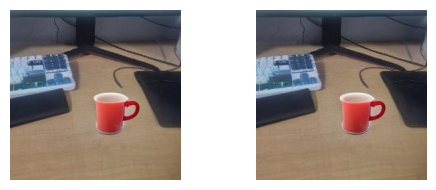

In [ ]:
%matplotlib inline

# @title 2.2.3 Display input images

from glob import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Pre-defined function
def display_images(image_paths, n_images_per_row = 4):
    n_rows = math.ceil(len(image_paths) / n_images_per_row)

    plt.figure(figsize=(10, 2 * n_rows))  # Adjust the size as needed
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_images_per_row, i + 1)  # Number of rows, number of images per row, current index
        plt.imshow(img)
        plt.axis('off')  # To not display axis

    plt.tight_layout()
    plt.show()


image_paths = glob(os.path.join(input_dir, "*"))

display_images(image_paths)

In [ ]:
# @title ▶️ 2.2.4 Run inference (default settings are for LCM)
denoising_steps = 4 # @param {type:"integer"}
ensemble_size = 5 # @param {type:"integer"}
processing_res = 768 # @param {type:"integer"}
match_input_res = True # @param ["False", "True"]
# use_seed = True # @param ["False", "True"]
# seed = 2024 # @param {type:"integer"}

# if not use_seed:
#     seed = None

import logging
import numpy as np
import torch
from tqdm.auto import tqdm
from glob import glob
from PIL import Image


EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

# Image list
rgb_filename_list = glob(os.path.join(input_dir, "*"))
rgb_filename_list = [
    f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
]
rgb_filename_list = sorted(rgb_filename_list)

# Create output folders
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_color, exist_ok=True)
os.makedirs(output_dir_tif, exist_ok=True)
os.makedirs(output_dir_npy, exist_ok=True)

# Run Inference
with torch.no_grad():
    os.makedirs(output_dir, exist_ok=True)

    for rgb_path in tqdm(rgb_filename_list, desc=f"Estimating depth", leave=True):
        # Read input image
        input_image = Image.open(rgb_path)

        # Predict depth
        pipeline_output = pipe(
            input_image,
            denoising_steps=denoising_steps,     # optional
            ensemble_size=ensemble_size,       # optional
            processing_res=processing_res,     # optional
            match_input_res=match_input_res,   # optional
            batch_size=0,           # optional
            color_map="Spectral",   # optional
            show_progress_bar=True, # optional
            # seed=seed,              # optional
        )

        depth_pred: np.ndarray = pipeline_output.depth_np
        depth_colored: Image.Image = pipeline_output.depth_colored

        # Save as npy
        rgb_name_base = os.path.splitext(os.path.basename(rgb_path))[0]
        pred_name_base = rgb_name_base + "_pred"
        npy_save_path = os.path.join(output_dir_npy, f"{pred_name_base}.npy")
        if os.path.exists(npy_save_path):
            logging.warning(f"Existing file: '{npy_save_path}' will be overwritten")
        np.save(npy_save_path, depth_pred)

        # Save as 16-bit uint png
        depth_to_save = (depth_pred * 65535.0).astype(np.uint16)
        png_save_path = os.path.join(output_dir_tif, f"{pred_name_base}.png")
        if os.path.exists(png_save_path):
            logging.warning(f"Existing file: '{png_save_path}' will be overwritten")
        Image.fromarray(depth_to_save).save(png_save_path, mode="I;16")

        # Colorize
        colored_save_path = os.path.join(
            output_dir_color, f"{pred_name_base}_colored.png"
        )
        if os.path.exists(colored_save_path):
            logging.warning(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored.save(colored_save_path)

Estimating depth:   0%|          | 0/2 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/3 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/4 [00:00<?, ?it/s]

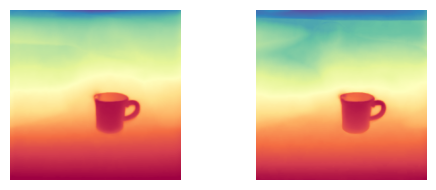

In [ ]:
%matplotlib inline

# @title 2.2.5 Display predictions

output_images_colored  = glob(os.path.join(output_dir_color, "*"))
display_images(output_images_colored)


In [ ]:
import shutil
import os
from google.colab import files

# 압축할 폴더 경로
folder_path = "/content/Marigold/output"
zip_filename = "/content/output_folders.zip"  # 압축파일 저장 경로

# 폴더를 zip 파일로 압축
shutil.make_archive(zip_filename.replace(".zip", ""), 'zip', folder_path)

# 파일 다운로드
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>